In [40]:
import os
import math
import matplotlib.pyplot as plt
%matplotlib inline

Follow tuturial at https://digitalslidearchive.github.io/HistomicsTK/examples/nuclei-segmentation.html

In [41]:
import histomicstk as htk
import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.patches as mpatches

In [39]:
tiles_dir = "/srv/dh-mcw_research/tiles/prostate_he_tiles_0.5x"

In [7]:
tile_names = ["247_12_x0.5__18432_63488.png","247_12_x0.5__18432_64512.png","247_12_x0.5__18432_65536.png","247_12_x0.5__18432_66560.png","247_12_x0.5__18432_67584.png","247_12_x0.5__18432_68608.png","247_12_x0.5__18432_69632.png","247_12_x0.5__18432_70656.png","247_12_x0.5__18432_7168.png","247_12_x0.5__18432_71680.png","247_12_x0.5__18432_72704.png","247_12_x0.5__18432_73728.png","247_12_x0.5__18432_74752.png","247_12_x0.5__18432_75776.png","247_12_x0.5__18432_76800.png","247_12_x0.5__18432_77824.png","247_12_x0.5__18432_78848.png","247_12_x0.5__18432_79872.png","247_12_x0.5__18432_80896.png","247_12_x0.5__18432_8192.png","247_12_x0.5__18432_81920.png","247_12_x0.5__18432_82944.png","247_12_x0.5__18432_83968.png","247_12_x0.5__18432_84992.png","247_12_x0.5__18432_86016.png","247_12_x0.5__18432_87040.png","247_12_x0.5__18432_88064.png","247_12_x0.5__18432_89088.png","247_12_x0.5__18432_90112.png","247_12_x0.5__18432_91136.png","247_12_x0.5__18432_9216.png","247_12_x0.5__18432_92160.png", "247_12_x0.5__18432_93184.png"]

In [8]:
len(tile_names)

33

In [14]:
def load_imgs(names, directory):
    imgs = []
    for name in names:
        img_path = os.path.join(directory,name)
        img = skimage.io.imread(img_path)[:, :, :3]
        imgs.append(img)
    return imgs

In [15]:
imgs = load_imgs(tile_names, tiles_dir)

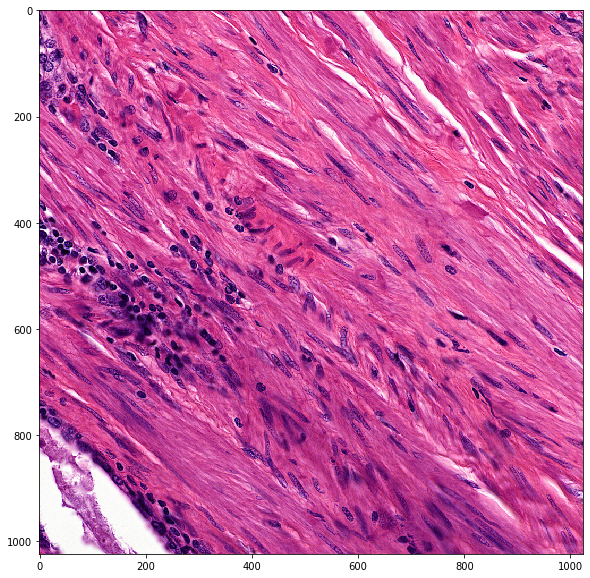

In [18]:
plt.imshow(imgs[15])

In [56]:
test_img = imgs[1].copy()
im_input = test_img.copy()

In [45]:
def plot_imgs(imgs):
    n_col = 4
    n_row = math.ceil(len(imgs)/n_col)
    _, axs = plt.subplots(n_row, n_col, figsize=(20, 30))
    axs = axs.flatten()
    for index, (img, ax) in enumerate(zip(imgs, axs)):
        ax.set_title(index)
        ax.imshow(img)
    plt.show()

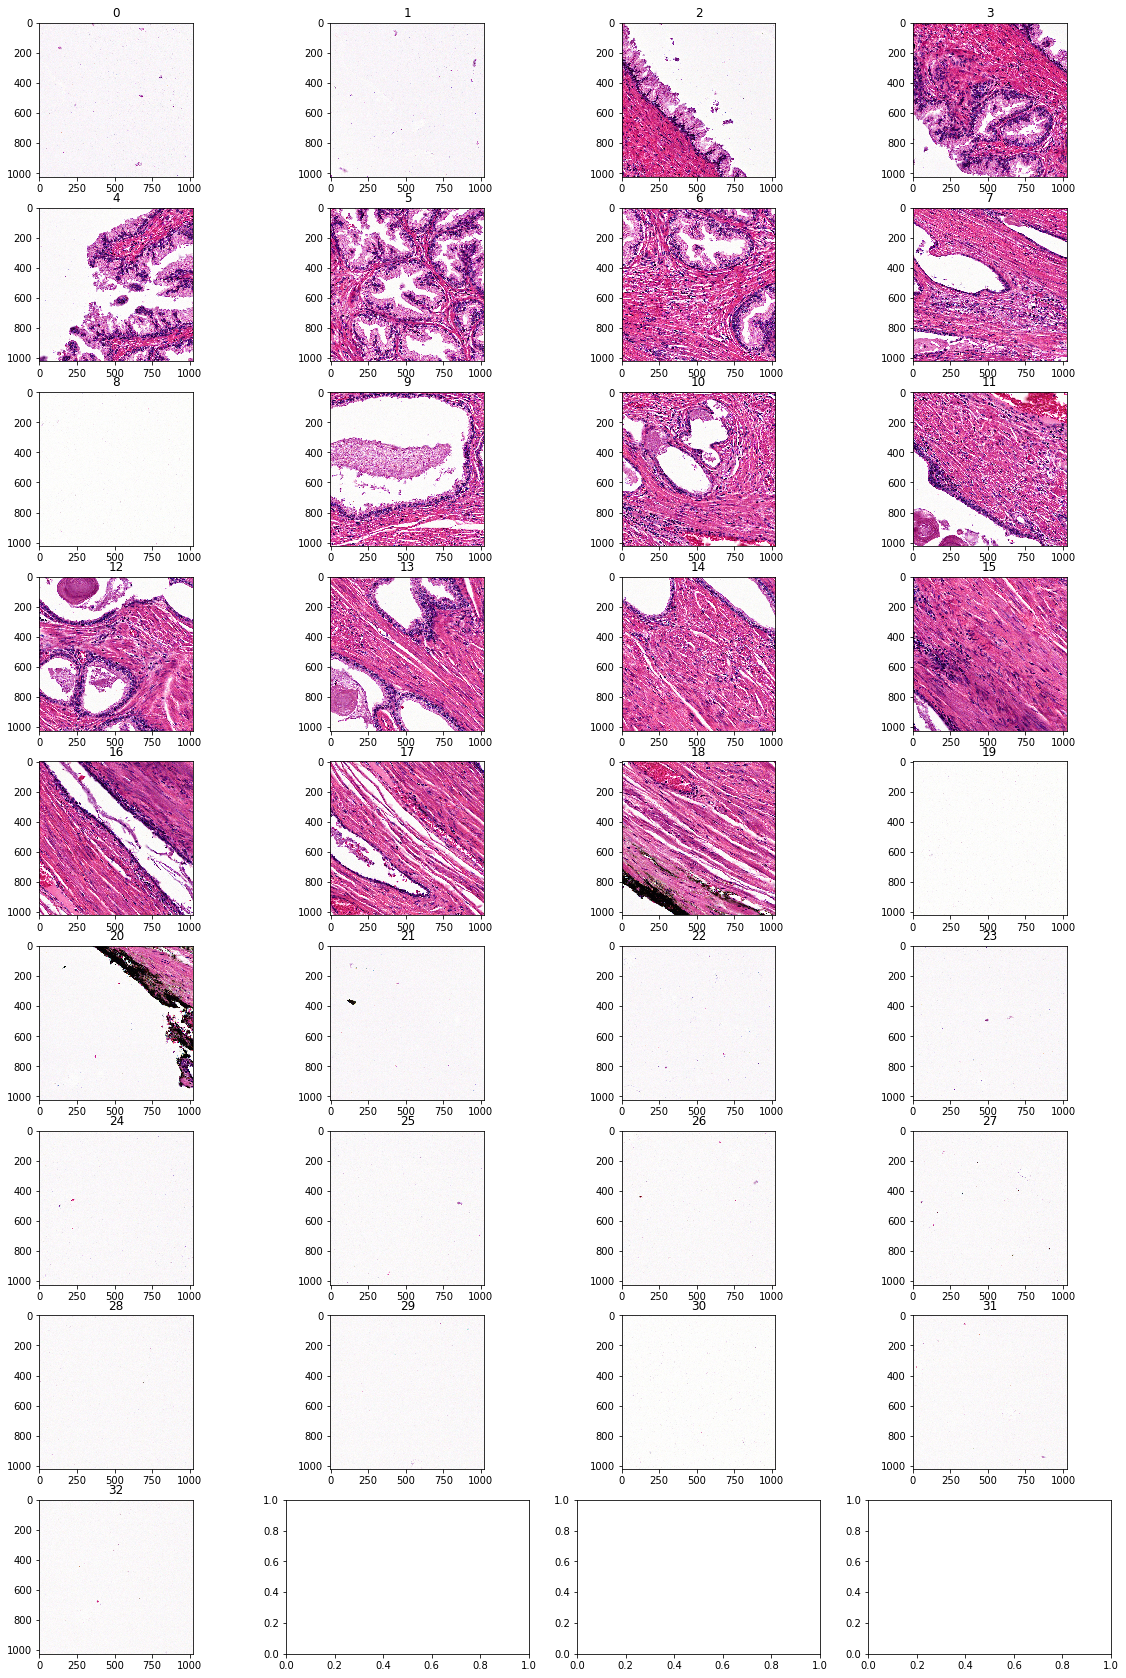

In [46]:
plot_imgs(imgs)

Number of nuclei =  0


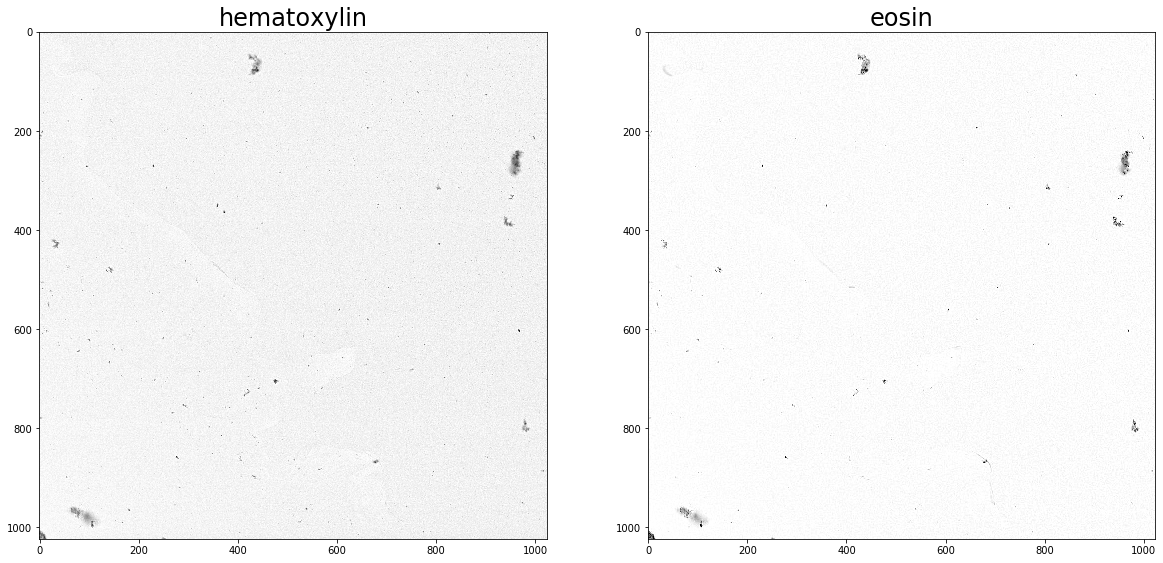

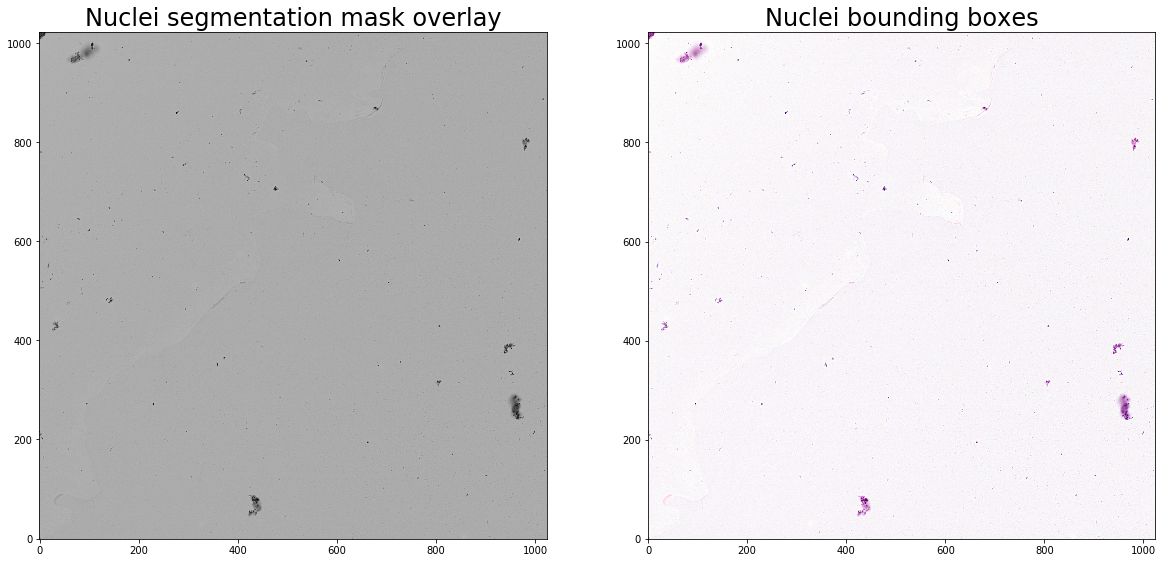

In [61]:
segment_nuclei(test_img)

In [68]:

# create stain to color map
stainColorMap = {
    'hematoxylin': [0.65, 0.70, 0.29],
    'eosin':       [0.07, 0.99, 0.11],
    'dab':         [0.27, 0.57, 0.78],
    'null':        [0.0, 0.0, 0.0]
}
    
def segment_nuclei_plot(he_img):
    # specify stains of input image
    stain_1 = 'hematoxylin'   # nuclei stain
    stain_2 = 'eosin'         # cytoplasm stain
    stain_3 = 'null'          # set to null of input contains only two stains

    # create stain matrix
    W = np.array([stainColorMap[stain_1],
                  stainColorMap[stain_2],
                  stainColorMap[stain_3]]).T

    # perform standard color deconvolution
    im_stains = htk.preprocessing.color_deconvolution.color_deconvolution(he_img, W).Stains

    # Display results
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(im_stains[:, :, 0])
    plt.title(stain_1, fontsize=titlesize)

    plt.subplot(1, 2, 2)
    plt.imshow(im_stains[:, :, 1])
    _ = plt.title(stain_2, fontsize=titlesize)
    
    # get nuclei/hematoxylin channel
    im_nuclei_stain = im_stains[:, :, 0]

    # segment foreground
    foreground_threshold = 60

    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        im_nuclei_stain < foreground_threshold)

    # run adaptive multi-scale LoG filter
    min_radius = 10
    max_radius = 15

    im_log_max, im_sigma_max = htk.filters.shape.cdog(
        im_nuclei_stain, im_fgnd_mask,
        sigma_min=min_radius * np.sqrt(2),
        sigma_max=max_radius * np.sqrt(2)
    )

    # detect and segment nuclei using local maximum clustering
    local_max_search_radius = 10

    im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
        im_log_max, im_fgnd_mask, local_max_search_radius)

    # filter out small objects
    min_nucleus_area = 80

    im_nuclei_seg_mask = htk.segmentation.label.area_open(
        im_nuclei_seg_mask, min_nucleus_area).astype(np.int)

    # compute nuclei properties
    objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

    print ('Number of nuclei = ', len(objProps))

    # Display results
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask, im_input, bg_label=0), origin='lower')
    plt.title('Nuclei segmentation mask overlay', fontsize=titlesize)

    plt.subplot(1, 2, 2)
    plt.imshow( im_input )
    plt.xlim([0, im_input.shape[1]])
    plt.ylim([0, im_input.shape[0]])
    plt.title('Nuclei bounding boxes', fontsize=titlesize)

    for i in range(len(objProps)):

        c = [objProps[i].centroid[1], objProps[i].centroid[0], 0]
        width = objProps[i].bbox[3] - objProps[i].bbox[1] + 1
        height = objProps[i].bbox[2] - objProps[i].bbox[0] + 1

        cur_bbox = {
            "type":        "rectangle",
            "center":      c,
            "width":       width,
            "height":      height,
        }

        plt.plot(c[0], c[1], 'g+')
        mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,
                                   width, height, fill=False, ec='g', linewidth=2)
        plt.gca().add_patch(mrect)

In [69]:
def get_nucleiod_count(he_img):
    # specify stains of input image
    stain_1 = 'hematoxylin'   # nuclei stain
    stain_2 = 'eosin'         # cytoplasm stain
    stain_3 = 'null'          # set to null of input contains only two stains

    # create stain matrix
    W = np.array([stainColorMap[stain_1],
                  stainColorMap[stain_2],
                  stainColorMap[stain_3]]).T

    # perform standard color deconvolution
    im_stains = htk.preprocessing.color_deconvolution.color_deconvolution(he_img, W).Stains

    
    # get nuclei/hematoxylin channel
    im_nuclei_stain = im_stains[:, :, 0]

    # segment foreground
    foreground_threshold = 60

    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        im_nuclei_stain < foreground_threshold)

    # run adaptive multi-scale LoG filter
    min_radius = 10
    max_radius = 15

    im_log_max, im_sigma_max = htk.filters.shape.cdog(
        im_nuclei_stain, im_fgnd_mask,
        sigma_min=min_radius * np.sqrt(2),
        sigma_max=max_radius * np.sqrt(2)
    )

    # detect and segment nuclei using local maximum clustering
    local_max_search_radius = 10

    im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
        im_log_max, im_fgnd_mask, local_max_search_radius)

    # filter out small objects
    min_nucleus_area = 80

    im_nuclei_seg_mask = htk.segmentation.label.area_open(
        im_nuclei_seg_mask, min_nucleus_area).astype(np.int)

    # compute nuclei properties
    objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

    print ('Number of nuclei = ', len(objProps))

    # Display results
    plt.figure(figsize=(20, 10))

    return len(objProps)